<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/deep_learning_school/part_2/homework_4/
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/deep_learning_school/part_2/homework_4
 best-val-model_89.pt
 best-val-model_90_05.pt
 best-val-model_full.pt
'Копия_блокнота__[homework]language_model_ipynb_.ipynb'


### Задача определения частей речи, Part-Of-Speech Tagger (POS)

Мы будем решать задачу определения частей речи (POS-теггинга) с помощью скрытой марковской модели (HMM).

In [ ]:
import nltk
import pandas as pd
import numpy as np
from collections import OrderedDict, deque#
from nltk.corpus import brown
import matplotlib.pyplot as plt

from torchtext.legacy.data import Field, BucketIterator
import torchtext

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Вам в помощь http://www.nltk.org/book/

Загрузим brown корпус

In [ ]:
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

Существует множество наборов грамматических тегов, или тегсетов, например:
* НКРЯ
* Mystem
* UPenn
* OpenCorpora (его использует pymorphy2)
* Universal Dependencies

<b>Существует не одна система тегирования, поэтому будьте внимательны, когда прогнозируете тег слов в тексте и вычисляете качество прогноза. Можете получить несправедливо низкое качество вашего решения.

На данный момент стандартом является **Universal Dependencies**. Подробнее про проект можно почитать [вот тут](http://universaldependencies.org/), а про теги — [вот тут](http://universaldependencies.org/u/pos/)

In [ ]:
nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

<img src="https://4.bp.blogspot.com/-IcFli2wljs0/WrVCw3umY_I/AAAAAAAACYM/UJ_neoUAs3wF95dj2Ouf3BzxXzB_b2TbQCLcBGAs/s1600/postags.png">


Мы имеем массив предложений пар (слово-тег)

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
brown_tagged_sents

[[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('City

In [ ]:
len(brown_tagged_sents)

57340

Первое предложение

In [ ]:
brown_tagged_sents[0]

[('The', 'DET'),
 ('Fulton', 'NOUN'),
 ('County', 'NOUN'),
 ('Grand', 'ADJ'),
 ('Jury', 'NOUN'),
 ('said', 'VERB'),
 ('Friday', 'NOUN'),
 ('an', 'DET'),
 ('investigation', 'NOUN'),
 ('of', 'ADP'),
 ("Atlanta's", 'NOUN'),
 ('recent', 'ADJ'),
 ('primary', 'NOUN'),
 ('election', 'NOUN'),
 ('produced', 'VERB'),
 ('``', '.'),
 ('no', 'DET'),
 ('evidence', 'NOUN'),
 ("''", '.'),
 ('that', 'ADP'),
 ('any', 'DET'),
 ('irregularities', 'NOUN'),
 ('took', 'VERB'),
 ('place', 'NOUN'),
 ('.', '.')]

Все пары (слово-тег)

In [ ]:
brown_tagged_words = brown.tagged_words(tagset='universal')
brown_tagged_words

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

Проанализируйте данные, с которыми Вы работаете. Используйте `nltk.FreqDist()` для подсчета частоты встречаемости тега и слова в нашем корпусе. Под частой элемента подразумевается кол-во этого элемента в корпусе.

In [ ]:
# Приведем слова к нижнему регистру
brown_tagged_words = list(map(lambda x: (x[0].lower(), x[1]), brown_tagged_words))

In [ ]:
from collections import Counter

print('Кол-во предложений: ', len(brown_tagged_sents))
tags = [tag for (word, tag) in brown_tagged_words] # наши теги
words = [word for (word, tag) in brown_tagged_words] # наши слова

stats_tag_num = Counter()
stats_tag_num.update(tags)
stats_tag_num = dict(stats_tag_num)

stats_word_num = Counter()
stats_word_num.update(words)
stats_word_num = dict(stats_word_num)



tag_num = pd.DataFrame({'tags': list(stats_tag_num.keys()),
                     'counts': list(stats_tag_num.values())
                     }).sort_values(by=['counts'], ascending=False) # тег - кол-во тега в корпусе
word_num = pd.DataFrame({'tags': list(stats_word_num.keys()),
                     'counts': list(stats_word_num.values())
                     }).sort_values(by=['counts'], ascending=False) # слово - кол-во слова в корпусе

Кол-во предложений:  57340


In [ ]:
tag_num

,tags,counts
1,NOUN,275558
3,VERB,182750
5,.,147565
4,ADP,144766
0,DET,137019
2,ADJ,83721
6,ADV,56239
9,PRON,49334
7,CONJ,38151
8,PRT,29829


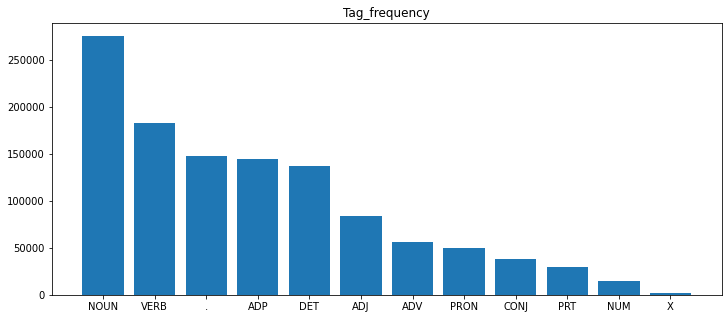

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(tag_num['tags'], tag_num['counts'])
plt.title("Tag_frequency")
plt.show()

In [ ]:
word_num[:5]

,tags,counts
0,the,69971
32,",",58334
24,.,49346
9,of,36412
39,and,28853


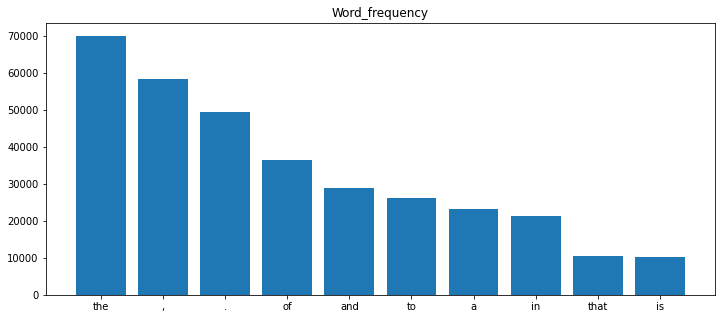

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(word_num.tags[:10], word_num.counts[:10])
plt.title("Word_frequency")
plt.show()

### Вопрос 1:
* Кол-во слова `cat` в корпусе?
Ответ = 23

In [ ]:
'''your code'''
word_num[word_num['tags'] == 'cat']['counts']

14373    23
Name: counts, dtype: int64

### Вопрос 2:
* Самое популярное слово с самым популярным тегом? <br>(*сначала выбираете слова с самым популярным тегом, а затем выбираете самое популярное слово из уже выбранных*)

Ответ '<b>to</b>'

In [ ]:
'''your code'''
most_popular_tag = 'NOUN'

top_words = set([])
for i in range(len(tags)):
  tag = tags[i]
  if tag == most_popular_tag:
    word = words[i]
    top_words.update([word])

In [ ]:
get_word_count = lambda w: int(word_num[word_num['tags'] == w]['counts']) 
top_words = list(top_words)

top_words_counts = [get_word_count(item) for item in top_words]

In [ ]:
pd.DataFrame({'words': top_words,
                     'counts': top_words_counts
                     }).sort_values(by=['counts'], ascending=False)

,words,counts
27996,to,26158
12913,a,23195
11260,in,21337
22141,for,9489
28336,i,5164
...,...,...
14122,arylesterases,1
14125,timetables,1
14126,bani,1
14128,nibelungenlied,1


Впоследствии обучение моделей может занимать слишком много времени, работайте с подвыборкой, например, только текстами определенных категорий.

Категории нашего корпуса:

In [ ]:
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

Будем работать с категорией humor

Cделайте случайное разбиение выборки на обучение и контроль в отношении 9:1. 

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal", categories='humor')
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown_tagged_sents:
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents, test_sents = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
len(train_sents)

947

In [ ]:
len(test_sents)

106

### Метод максимального правдоподобия для обучения модели

* $\normalsize S = s_0, s_1, ..., s_N$ - скрытые состояния, то есть различные теги
* $\normalsize O = o_0, o_1, ..., o_M$ - различные слова
* $\normalsize a_{i,j} = p(s_j|s_i)$ - вероятность того, что, находясь в скрытом состоянии $s_i$, мы попадем в состояние $s_j$ (элемент матрицы $A$)
* $\normalsize b_{k,j}=p(o_k|s_j)$ - вероятность того, что при скрытом состоянии $s_j$ находится слово $o_k$(элемент матрицы $B$)

$$\normalsize x_t \in O, y_t \in S$$
$\normalsize (x_t, y_t)$ - слово и тег, стоящие на месте $t$ $\Rightarrow$ 
* $\normalsize X$ - последовательность слов
* $\normalsize Y$ - последовательность тегов

Требуется построить скрытую марковскую модель (class HiddenMarkovModel) и написать метод fit для настройки всех её параметров с помощью оценок максимального правдоподобия по размеченным данным (последовательности пар слово+тег):

- Вероятности переходов между скрытыми состояниями $p(y_t | y_{t - 1})$ посчитайте на основе частот биграмм POS-тегов.


- Вероятности эмиссий наблюдаемых состояний $p(x_t | y_t)$ посчитайте на основе частот "POS-тег - слово".


- Распределение вероятностей начальных состояний $p(y_0)$ задайте равномерным.

Пример $X = [x_0, x_1], Y = [y_0, y_1]$:<br><br>
$$p(X, Y) = p(x_0, x_1, y_0, y_1) = p(y_0) \cdot p(x_0, x_1, y_1 | y_0) = p(y_0) \cdot p(x_0 | y_0) \cdot
p(x_1, y_1 | x_0, y_0) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | x_0, y_0) \cdot p(x_1 | x_0, y_0, y_1)
= (\text{в силу условий нашей модели}) = \\ = p(y_0) \cdot p(x_0 | y_0) \cdot p(y_1 | y_0) \cdot p(x_1 | y_1) \Rightarrow$$ <br>
Для последовательности длины $n + 1$:<br>
$$p(X, Y) = p(x_0 ... x_{n - 1}, y_0 ... y_{n - 1}) \cdot p(y_n | y_{n - 1}) \cdot p(x_n | y_n)$$

#### Алгоритм Витерби для применения модели


Требуется написать метод .predict для определения частей речи на тестовой выборке. Чтобы использовать обученную модель на новых данных, необходимо реализовать алгоритм Витерби. Это алгоритм динамиеского программирования, с помощью которого мы будем находить наиболее вероятную последовательность скрытых состояний модели для фиксированной последовательности слов:

$$ \hat{Y} = \arg \max_{Y} p(Y|X) = \arg \max_{Y} p(Y, X) $$

Пусть $\normalsize Q_{t,s}$ - самая вероятная последовательность скрытых состояний длины $t$ с окончанием в состоянии $s$. $\normalsize q_{t, s}$ - вероятность этой последовательности.
$$(1)\: \normalsize q_{t,s} = \max_{s'} q_{t - 1, s'} \cdot p(s | s') \cdot p(o_t | s)$$
$\normalsize Q_{t,s}$ можно восстановить по argmax-ам.

In [ ]:
class HiddenMarkovModel:    
    def __init__(self):
    
        pass
        
    def fit(self, train_tokens_tags_list):
        """
        train_tokens_tags_list: массив предложений пар слово-тег (выборка для train) 
        """
        tags = [tag for sent in train_tokens_tags_list
                for (word, tag) in sent]
        words = [word for sent in train_tokens_tags_list
                 for (word, tag) in sent]

        stats_tag_num = Counter()
        stats_tag_num.update(tags)
        # stats_tag_num = dict(stats_tag_num)

        stats_word_num = Counter()
        stats_word_num.update(words)
        # stats_word_num = dict(stats_word_num)
        
        tag_num = pd.Series(stats_tag_num).sort_index()
        word_num = pd.Series(stats_word_num).sort_values(ascending=False)
         
        self.tags = tag_num.index
        self.words = word_num.index
        
        A = pd.DataFrame({'{}'.format(tag) : [0] * len(tag_num) for tag in tag_num.index}, index=tag_num.index)
        B = pd.DataFrame({'{}'.format(tag) : [0] * len(word_num) for tag in tag_num.index}, index=word_num.index)
        
        # Вычисляем матрицу A и B по частотам слов и тегов
        
        # sent - предложение
        # sent[i][0] - i слово в этом предложении, sent[i][1] - i тег в этом предложении
        for sent in train_tokens_tags_list:
            for i in range(len(sent)):
                # B.loc['''your code'''] += 1 # текущая i-пара слово-тег (обновите матрицу B аналогично A)
                B.loc[sent[i][0], sent[i][1]] += 1
                if len(sent) - 1 != i: # для последнего тега нет следующего тега
                    A.loc[sent[i][1], sent[i + 1][1]] += 1 # пара тег-тег
                
        
        # переходим к вероятностям
        
        # нормируем по строке, то есть по всем всевозможным следующим тегам
        A = A.divide(A.sum(axis=1), axis=0)
        
        # нормируем по столбцу, то есть по всем всевозможным текущим словам
        B = B / np.sum(B, axis=0)
        
        self.A = A
        self.B = B
        
        return self
        
    
    def predict(self, test_tokens_list):
        """
        test_tokens_list : массив предложений пар слово-тег (выборка для test)
        """
        predict_tags = OrderedDict({i : np.array([]) for i in range(len(test_tokens_list))})
        
        for i_sent in range(len(test_tokens_list)):
            
            current_sent = test_tokens_list[i_sent] # текущее предложение
            len_sent = len(current_sent) # длина предложения 
            
            q = np.zeros(shape=(len_sent + 1, len(self.tags)))
            q[0] = 1 # нулевое состояние (равномерная инициализация по всем s)
            back_point = np.zeros(shape=(len_sent + 1, len(self.tags))) # # argmax
            
            for t in range(len_sent):
                
                # если мы не встречали такое слово в обучении, то вместо него будет 
                # самое популярное слово с самым популярным тегом (вопрос 2)
                if current_sent[t] not in self.words:
                    # current_sent[t] = '''your code'''
                    current_sent[t] = 'time'
                    
                # через max выбираем следующий тег
                for i_s in range(len(self.tags)):
                    
                    s = self.tags[i_s]
                    
                    # формула (1)
                    # q[t + 1][i_s] = np.max(q['''your code'''] *
                    #     self.A.loc[:, '''your code'''] * 
                    #     self.B.loc[current_sent[t], s])
                    q[t + 1][i_s] = np.max(q[t,:] *
                        self.A.loc[:, s] * 
                        self.B.loc[current_sent[t], s])
                    
                    # argmax формула(1)
                    
                    # argmax, чтобы восстановить последовательность тегов
                    # back_point[t + 1][i_s] = (q['''your code'''] * self.A.loc[:, '''your code'''] * 
                    #     self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс
                    back_point[t + 1][i_s] = (q[t,:] * self.A.loc[:, s] * 
                        self.B.loc[current_sent[t],s]).reset_index()[s].idxmax() # индекс 
                    
            back_point = back_point.astype('int')
            
            # выписываем теги, меняя порядок на реальный
            back_tag = deque()
            current_tag = np.argmax(q[len_sent])
            for t in range(len_sent, 0, -1):
                back_tag.appendleft(self.tags[current_tag])
                current_tag = back_point[t, current_tag]
             
            predict_tags[i_sent] = np.array(back_tag)
        
        
        return predict_tags                 

Обучите скрытую марковскую модель:

In [ ]:
# my_model = ..,
'''your code'''
my_model = HiddenMarkovModel()
my_model.fit(train_sents)

Проверьте работу реализованного алгоритма на следующих модельных примерах, проинтерпретируйте результат.

- 'He can stay'
- 'a cat and a dog'
- 'I have a television'
- 'My favourite character'

In [ ]:
sents = [['He', 'can', 'stay'], ['a', 'cat', 'and', 'a', 'dog'], ['I', 'have', 'a', 'television'],
         ['My', 'favourite', 'character']]
'''your code'''
pred = my_model.predict(sents)
pred

OrderedDict([(0, array(['NOUN', 'VERB', 'VERB'], dtype='<U4')),
             (1, array(['DET', 'NOUN', 'CONJ', 'DET', 'NOUN'], dtype='<U4')),
             (2, array(['NOUN', 'VERB', 'DET', 'NOUN'], dtype='<U4')),
             (3, array(['NOUN', 'NOUN', 'NOUN'], dtype='<U4'))])

### Вопрос 3:
* Какой тег вы получили для слова `can`?\
Ответ = 'VERB'

In [ ]:
'''your code'''

'your code'

### Вопрос 4:
* Какой тег вы получили для слова `favourite`?\
Ответ = 'NOUN'

In [ ]:
'''your code'''

Примените модель к отложенной выборке Брауновского корпуса и подсчитайте точность определения тегов (accuracy). Сделайте выводы. 

In [ ]:
def accuracy_score(model, sents):
    true_pred = 0
    num_pred = 0

    for sent in sents:
        # tags = '''your code'''
        # words = '''your code'''
        tags = [item[1] for item in sent]
        words = [item[0] for item in sent]

        pred = model.predict([words])[0]

        tags_pred = np.sum([tags == pred])

        true_pred += tags_pred
        num_pred += len(pred)
    print("Accuracy:", true_pred / num_pred * 100, '%')

In [ ]:
accuracy_score(my_model, test_sents)

Accuracy: 88.82847256549678 %


### Вопрос 5:
* Какое качество вы получили(округлите до одного знака после запятой)?

In [ ]:
'''your code'''
88.8

88.8

## DefaultTagger

### Вопрос 6:
* Какое качество вы бы получили, если бы предсказывали любой тег, как самый популярный тег на выборке train(округлите до одного знака после запятой)?

Вы можете испоьзовать DefaultTagger(метод tag для предсказания частей речи предложения)

In [ ]:
from nltk.tag import DefaultTagger
default_tagger = DefaultTagger("NOUN")

In [ ]:
class MyDefaultTagger(DefaultTagger):
  def __init__(self, *args):
    super().__init__(args)
  def predict(self, words):
    return [np.array([tag[1][0] for tag in self.tag(item)]) for item in words ]
my_default_tagger = MyDefaultTagger("NOUN")

In [ ]:
accuracy_score(my_default_tagger, test_sents)

Accuracy: 20.217498764211566 %


## NLTK, Rnnmorph

Вспомним первый [семинар](https://colab.research.google.com/drive/1FHZVU6yJT61J8w1hALno0stD4VU36rit?usp=sharing) нашего курса. В том семинаре мы с вами работали c некоторыми библиотеками.

Не забудьте преобразовать систему тэгов из `'en-ptb' в 'universal'` с помощью функции `map_tag` или используйте `tagset='universal'`

In [ ]:
from nltk.tag.mapping import map_tag

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
# nltk.pos_tag(..., tagset='universal')

In [ ]:
!pip install rnnmorph

In [ ]:
from rnnmorph.predictor import RNNMorphPredictor
predictor = RNNMorphPredictor(language="en")

In [ ]:
predictor.predict(['qwe', 'qwe'])

[<normal_form=qwe; word=qwe; pos=VERB; tag=Mood=Ind|Tense=Pres|VerbForm=Fin; score=0.5480>,
 <normal_form=qwe; word=qwe; pos=NOUN; tag=Number=Sing; score=0.4814>]

In [ ]:

class MyPredictorModel:
  def predict(self, sents):
    predicted_tags = []
    for sent in sents:
      pred_tags = np.array([str(item.pos) for item in predictor.predict(sent)])
      predicted_tags.append(pred_tags)

    return np.array(predicted_tags)

myPredictor = MyPredictorModel()


In [ ]:
accuracy_score(myPredictor, test_sents)

Accuracy: 62.827483934750376 %


### Вопрос 7:
* Какое качество вы получили, используя каждую из двух библиотек? Сравните их результаты.

* Качество с библиотекой rnnmorph должно быть хуже, так как там используется немного другая система тэгов. Какие здесь отличия?

In [ ]:
'''your code'''
# Markov Model = 88%
# RNN Tagger = 62%

'your code'

## BiLSTMTagger

### Подготовка данных

Изменим структуру данных

In [ ]:
pos_data = [list(zip(*sent)) for sent in brown.tagged_sents(tagset="universal", categories='humor')]
print(pos_data[0])

[('It', 'was', 'among', 'these', 'that', 'Hinkle', 'identified', 'a', 'photograph', 'of', 'Barco', '!', '!'), ('PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.')]


До этого мы писали много кода сами, теперь пора эксплуатировать pytorch

In [ ]:

# наши поля
WORD = Field(lower=True)
TAG = Field(unk_token=None) # все токены нам извсетны

# создаем примеры
examples = []
for words, tags in pos_data:
    examples.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], fields=[('words', WORD), ('tags', TAG)]))

Вот один наш пример:

In [ ]:
print(vars(examples[0]))

{'words': ['it', 'was', 'among', 'these', 'that', 'hinkle', 'identified', 'a', 'photograph', 'of', 'barco', '!', '!'], 'tags': ['PRON', 'VERB', 'ADP', 'DET', 'ADP', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', '.', '.']}


Теперь формируем наш датасет

In [ ]:
# кладем примеры в наш датасет
dataset = torchtext.legacy.data.Dataset(examples, fields=[('words', WORD), ('tags', TAG)])

train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.1, 0.1])

print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 842
Number of validation examples: 106
Number of testing examples: 105


Построим словари. Параметр `min_freq` выберете сами. При построении словаря испольузем только **train**

In [ ]:
WORD.build_vocab(train_data, min_freq=2)
TAG.build_vocab(train_data,)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG.vocab)}")

print(WORD.vocab.itos[::200])
print(TAG.vocab.itos)

Unique tokens in source (ru) vocabulary: 1298
Unique tokens in target (en) vocabulary: 13
['<unk>', 'viola', 'care', 'grazie', 'buying', 'knee-length', 'spoke']
['<pad>', 'NOUN', 'VERB', '.', 'DET', 'ADP', 'PRON', 'ADJ', 'ADV', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
print(vars(train_data.examples[9]))

{'words': ['however', 'one', 'looks', 'at', 'it', ',', 'therefore', ',', "i'd", 'say', 'that', 'your', 'horoscope', 'for', 'this', 'autumn', 'is', 'the', 'reverse', 'of', 'rosy', '.'], 'tags': ['ADV', 'NOUN', 'VERB', 'ADP', 'PRON', '.', 'ADV', '.', 'PRT', 'VERB', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'VERB', 'DET', 'NOUN', 'ADP', 'ADJ', '.']}


Посмотрим с насколько большими предложениями мы имеем дело

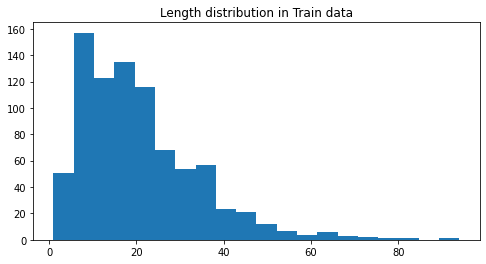

In [ ]:
length = map(len, [vars(x)['words'] for x in train_data.examples])

plt.figure(figsize=[8, 4])
plt.title("Length distribution in Train data")
plt.hist(list(length), bins=20);

Для обучения `BiLSTM` лучше использовать colab

Для более быстрого и устойчивого обучения сгруппируем наши данные по батчам

In [ ]:

BATCH_SIZE = 220

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [ ]:
# посморим  на количество батчей
list(map(len, [train_iterator, valid_iterator, test_iterator]))

[4, 1, 1]

### Модель и её обучение

Инициализируем нашу модель

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim=100, 
                 emb_dim=100, 
                 hid_dim=100, 
                 output_dim=100, 
                 dropout=0.2, 
                 bidirectional=False,
                 num_layers=1):
        super().__init__()

        self.embeddings = nn.Embedding(input_dim, emb_dim)
        self.dropout = nn.Dropout(p=dropout)
        
        self.rnn = nn.LSTM(input_size=emb_dim, 
                           hidden_size=hid_dim, 
                           bidirectional=bidirectional, 
                           dropout=dropout
                           )
        # если bidirectional, то предсказываем на основе конкатенации двух hidden
        self.tag = nn.Linear((1 + bidirectional) * hid_dim , output_dim)
        self.norm = nn.LayerNorm(emb_dim)
       
    def forward(self, sent):

        embedded = self.embeddings(sent)
        embedded = self.norm(embedded)
        embedded = self.dropout(embedded)

        output, (hidden, cell) = self.rnn(embedded)
        # print(output.shape, hidden.shape)
        # hidden = self.tanh(torch.cat([hidden[-1,:,:], hidden[-2,:,:]], 1))

      
        prediction = self.tag(
            self.dropout(output)
        )
    
        return prediction
        


Погнали обучать

In [ ]:
# бьем нашу выборку на батч, не забывая сначала отсортировать выборку по длине
def _len_sort_key(x):
    return len(x.words)



def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
      '''your code'''
      # print(batch)
      batch_words = batch.words
      optimizer.zero_grad()
      
      output = model(batch_words)
      
      #tags = [sent len, batch size]
      #output = [sent len, batch size, output dim]
      
      # output = '''your code'''
      tags = batch.tags
      output = output.view(output.size()[0] * len(batch), 13)
      tags = tags.view(-1)
      
      #tags = [sent len * batch size]
      #output = [sent len * batch size, output dim]
      # print(output.size(), tags.size())
      loss = criterion(output, tags)
      
      loss.backward()
      
      # Gradient clipping(решение проблемы взрыва граденты), clip - максимальная норма вектора
      # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip)
      
      optimizer.step()
      
      epoch_loss += loss.item()
      
      history.append(loss.cpu().data.numpy())
      if (i+1)%10==0 and False:
          fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

          # clear_output(True)
          ax[0].plot(history, label='train loss')
          ax[0].set_xlabel('Batch')
          ax[0].set_title('Train loss')
          
          if train_history is not None:
              ax[1].plot(train_history, label='general train history')
              ax[1].set_xlabel('Epoch')
          if valid_history is not None:
              ax[1].plot(valid_history, label='general valid history')
          plt.legend()
            
          plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
  model.eval()
  
  epoch_loss = 0
  
  history = []
  
  with torch.no_grad():
  
      for i, batch in enumerate(iterator):

          '''your code'''

          output = model(batch.words)

          #tags = [sent len, batch size]
          #output = [sent len, batch size, output dim]

          # output = '''your code'''
          tags = batch.tags
          tags = tags.view(-1)

          #tags = [sent len * batch size]
          #output = [sent len * batch size, output dim]
          output = output.view(output.size()[0] * len(batch), 13)

          loss = criterion(output, tags)
          
          epoch_loss += loss.item()
      
  return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
next(iter(train_iterator))


[torchtext.legacy.data.batch.Batch of size 32]
	[.words]:[torch.LongTensor of size 57x32]
	[.tags]:[torch.LongTensor of size 57x32]

In [ ]:
torch.ones((66, 32, 13)).view(66*32, 13).size()

torch.Size([2112, 13])

In [ ]:
int(next(iter(train_iterator)).words[0].size()[0])

32

In [ ]:
print(model)

LSTMTagger(
  (embeddings): Embedding(1280, 3)
  (dropout): Dropout(p=0, inplace=False)
  (rnn): LSTM(3, 4, bidirectional=True)
  (tag): Linear(in_features=8, out_features=13, bias=True)
  (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
)


In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,261 trainable parameters


In [ ]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [ ]:
PAD_IDX = TAG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 500
CLIP = 1.8

# параметры модели
params = {
  'input_dim': len(WORD.vocab.itos),
  'output_dim': len(TAG.vocab.itos),
  'emb_dim': 11,
  'hid_dim': 11,
  'dropout': 0.38,
  'bidirectional': True,
  'num_layers': 2
}
MODEL_LR = 5e-2

model = LSTMTagger(**params).to(device)

optimizer = optim.AdamW(model.parameters(),lr=MODEL_LR)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.10, 0.10)
        
model.apply(init_weights)
# model.load_state_dict(torch.load('best-val-model_89.pt'))

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
print(f"Best valid loss {best_valid_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 01 | Time: 0m 0s
	Train Loss: 2.400 | Train PPL:  11.019
	 Val. Loss: 2.225 |  Val. PPL:   9.255
Epoch: 02 | Time: 0m 0s
	Train Loss: 2.185 | Train PPL:   8.887
	 Val. Loss: 2.089 |  Val. PPL:   8.077
Epoch: 03 | Time: 0m 0s
	Train Loss: 1.976 | Train PPL:   7.215
	 Val. Loss: 1.673 |  Val. PPL:   5.330
Epoch: 04 | Time: 0m 0s
	Train Loss: 1.607 | Train PPL:   4.987
	 Val. Loss: 1.297 |  Val. PPL:   3.659
Epoch: 05 | Time: 0m 0s
	Train Loss: 1.306 | Train PPL:   3.693
	 Val. Loss: 0.994 |  Val. PPL:   2.702
Epoch: 06 | Time: 0m 0s
	Train Loss: 1.106 | Train PPL:   3.021
	 Val. Loss: 0.826 |  Val. PPL:   2.283
Epoch: 07 | Time: 0m 0s
	Train Loss: 0.967 | Train PPL:   2.631
	 Val. Loss: 0.697 |  Val. PPL:   2.009
Epoch: 08 | Time: 0m 0s
	Train Loss: 0.856 | Train PPL:   2.353
	 Val. Loss: 0.597 |  Val. PPL:   1.816
Epoch: 09 | Time: 0m 0s
	Train Loss: 0.785 | Train PPL:   2.193
	 Val. Loss: 0.537 |  Val. PPL:   1.710
Epoch: 10 | Time: 0m 0s
	Train Loss: 0.718 | Train PPL:   2.051


### Применение модели

In [ ]:
def accuracy_model(model, iterator):
  model.eval()
    
  true_pred = 0
  num_pred = 0
    
  with torch.no_grad():
    for i, batch in enumerate(iterator):
      '''your code'''
      output = model(batch.words)
      true_tags = batch.tags
      
      output = F.log_softmax(output, dim=2)
      output = torch.argmax(output, dim=2)
      
      output = output.view(-1)
      true_tags = true_tags.view(-1)
      predict_tags = output

      true_pred = torch.sum((true_tags == predict_tags) & (true_tags != PAD_IDX))
      num_pred = torch.prod(torch.tensor(true_tags.shape)) - (true_tags == PAD_IDX).sum()

      true_pred, num_pred = int(true_pred), int(num_pred)
      true_pred += true_pred
      num_pred += num_pred
    
  return round(true_pred / num_pred * 100, 3)

In [ ]:
best_model = LSTMTagger(**params).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

print("Accuracy:", accuracy_model(best_model, test_iterator), '%')

Accuracy: 90.257 %


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.38 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Подсчитаем количество обучаемых параметров нашей модели

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(best_model):,} trainable parameters')

The model has 16,711 trainable parameters


Вы можете улучшить качество, изменяя параметры модели. Но чтобы добиться нужного качества, вам неообходимо взять все выборку, а не только категорию `humor`.

In [ ]:
brown_tagged_sents_full = brown.tagged_sents(tagset="universal")
pos_data_full = [list(zip(*sent)) for sent in brown_tagged_sents_full]

WORD_FULL = Field(lower=True)
TAG_FULL = Field(unk_token=None)

examples_full = []
for words, tags in pos_data_full:
    examples_full.append(torchtext.legacy.data.Example.fromlist([list(words), list(tags)], 
                                                    fields=[('words', WORD_FULL), ('tags', TAG_FULL)]))
    
dataset_full = torchtext.legacy.data.Dataset(examples_full, fields=[('words', WORD_FULL), ('tags', TAG_FULL)])
train_data_full, valid_data_full, test_data_full = dataset_full.split(split_ratio=[0.8, 0.1, 0.1])


WORD_FULL.build_vocab(train_data_full, min_freq=10)
TAG_FULL.build_vocab(train_data_full,)

print(f"Unique tokens in source (ru) vocabulary: {len(WORD_FULL.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TAG_FULL.vocab)}")

print(WORD_FULL.vocab.itos[::200])
print(TAG_FULL.vocab.itos)
BATCH_SIZE = 128
train_iterator_full, valid_iterator_full, test_iterator_full = BucketIterator.splits(
    (train_data_full, valid_data_full, test_data_full), 
    batch_size = BATCH_SIZE, 
    device = 'cuda',
    sort_key=_len_sort_key
)

Unique tokens in source (ru) vocabulary: 7286
Unique tokens in target (en) vocabulary: 13
['<unk>', 'war', 'love', 'island', 'theory', '15', 'carefully', 'personnel', 'politics', '11', 'introduced', 'pushed', 'author', 'description', 'patients', 'cleaning', 'constructed', 'albert', 'radical', 'frightened', 'pack', 'undoubtedly', 'anglo-saxon', 'anticipation', 'worn', 'solely', 'lesser', 'composite', 'straightened', 'humble', 'a.l.a.m.', 'neighbor', 'bloom', 'joints', 'vince', 'forthcoming', 'short-term']
['<pad>', 'NOUN', 'VERB', '.', 'ADP', 'DET', 'ADJ', 'ADV', 'PRON', 'CONJ', 'PRT', 'NUM', 'X']


In [ ]:
list(map(len, [train_iterator_full, valid_iterator_full, test_iterator_full]))

[359, 45, 45]

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 20
CLIP = 1.8

PAD_IDX = TAG_FULL.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

# параметры модели
params = {
  'input_dim': len(WORD_FULL.vocab.itos),
  'output_dim': len(TAG_FULL.vocab.itos),
  'emb_dim': 11,
  'hid_dim': 11,
  'dropout': 0.03,
  'bidirectional': True,
  'num_layers': 3
}
MODEL_LR = 1e-3



# params = {
# 'input_dim': len(WORD_FULL.vocab),
# 'output_dim': len(TAG_FULL.vocab),
# 'emb_dim': 200,
# 'hid_dim': 512,
# 'dropout': 0.4,
# 'bidirectional': True,
# 'num_layers': 2
# }
# MODEL_LR = 1e-5

model_full = LSTMTagger(**params).to(device)


optimizer_full = optim.AdamW(model_full.parameters(),lr=MODEL_LR)

# инициализируем веса
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model_full.apply(init_weights)
model_full.load_state_dict(torch.load('best-val-model_full_95_34_small.pt'))


best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model_full, train_iterator_full, optimizer_full, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model_full, valid_iterator_full, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_full.state_dict(), 'best-val-model_full.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
print(f"Best valid loss {best_valid_loss}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 01 | Time: 0m 4s
	Train Loss: 0.116 | Train PPL:   1.123
	 Val. Loss: 0.132 |  Val. PPL:   1.142
Epoch: 02 | Time: 0m 4s
	Train Loss: 0.113 | Train PPL:   1.119
	 Val. Loss: 0.131 |  Val. PPL:   1.140
Epoch: 03 | Time: 0m 4s
	Train Loss: 0.111 | Train PPL:   1.118
	 Val. Loss: 0.131 |  Val. PPL:   1.139
Epoch: 04 | Time: 0m 4s
	Train Loss: 0.110 | Train PPL:   1.116
	 Val. Loss: 0.130 |  Val. PPL:   1.139
Epoch: 05 | Time: 0m 4s
	Train Loss: 0.109 | Train PPL:   1.115
	 Val. Loss: 0.130 |  Val. PPL:   1.139
Epoch: 06 | Time: 0m 4s
	Train Loss: 0.108 | Train PPL:   1.114
	 Val. Loss: 0.130 |  Val. PPL:   1.139
Epoch: 07 | Time: 0m 4s
	Train Loss: 0.107 | Train PPL:   1.113
	 Val. Loss: 0.129 |  Val. PPL:   1.138
Epoch: 08 | Time: 0m 4s
	Train Loss: 0.107 | Train PPL:   1.112
	 Val. Loss: 0.129 |  Val. PPL:   1.138
Epoch: 09 | Time: 0m 4s
	Train Loss: 0.106 | Train PPL:   1.112
	 Val. Loss: 0.129 |  Val. PPL:   1.138
Epoch: 10 | Time: 0m 4s
	Train Loss: 0.105 | Train PPL:   1.111


Вам неоходимо добиться качества не меньше, чем `accuracy = 93 %` 

In [ ]:
best_model_full = LSTMTagger(**params).to(device)
best_model_full.load_state_dict(torch.load('best-val-model_full.pt'))

# best_model = LSTMTagger(**params).to(device)
# best_model.load_state_dict(torch.load('best-val-model.pt'))
# print("Accuracy:", accuracy_model(model, test_iterator_full), '%')
print("Accuracy:", accuracy_model(best_model_full, test_iterator_full), '%')
# print("Accuracy:", accuracy_model(best_model, test_iterator_full), '%')

Accuracy: 95.657 %


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
best_model_full = LSTMTagger(**params).to(device)
best_model_full.load_state_dict(torch.load('best-val-model_full.pt'))
acc = accuracy_model(best_model_full, test_iterator_full) 
print(acc)
assert acc >= 93

95.657


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Пример решение нашей задачи:

In [ ]:
def print_tags(model, data):
    model.eval()
    
    with torch.no_grad():
        words, _ = data
        example = torch.LongTensor([WORD_FULL.vocab.stoi[elem] for elem in words]).unsqueeze(1).to(device)
        
        output = model(example).argmax(dim=-1).cpu().numpy()
        tags = [TAG_FULL.vocab.itos[int(elem)] for elem in output]

        for token, tag in zip(words, tags):
            print(f'{token:15s}{tag}')

In [ ]:
print_tags(best_model_full, pos_data[-1])

From           VERB
what           DET
I              NOUN
was            VERB
able           ADJ
to             PRT
gauge          VERB
in             ADP
a              DET
swift          NOUN
,              .
greedy         ADJ
glance         NOUN
,              .
the            DET
figure         NOUN
inside         ADP
the            DET
coral-colored  NOUN
boucle         NOUN
dress          NOUN
was            VERB
stupefying     ADJ
.              .



## Сравните результаты моделей HiddenMarkov, LstmTagger:
* при обучение на маленькой части корпуса, например, на категории humor
* при обучении на всем корпусе

In [ ]:
brown_tagged_sents = brown.tagged_sents(tagset="universal")
# Приведем слова к нижнему регистру
my_brown_tagged_sents = []
for sent in brown.tagged_sents(tagset="universal"):
    my_brown_tagged_sents.append(list(map(lambda x: (x[0].lower(), x[1]), sent)))
my_brown_tagged_sents = np.array(my_brown_tagged_sents)

from sklearn.model_selection import train_test_split
train_sents_full, test_sents_full = train_test_split(my_brown_tagged_sents, test_size=0.1, random_state=0,)

my_model_markov_full = HiddenMarkovModel()
my_model_markov_full.fit(train_sents_full)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
accuracy_score(my_model_markov_full, test_sents_full)

Accuracy: 96.26295331104619 %


Ну как видим на маленьких объемах справилась лучше LSTM, а на больших марковская модель. Думаю можно из LSTM выжать больше но мне уже надоело.